<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-3-amg-basics/19-AMG-advanced-options-anisotropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# You may need to install pyamg
!pip3 install pyamg

In [1]:
import numpy as np
import scipy.io as sio
import pyamg
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import tri
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Anisotropic diffusion problem

In [12]:
stencil = pyamg.gallery.diffusion.diffusion_stencil_2d(type='FE', epsilon=0.001, theta=np.pi / 4.0)
A = pyamg.gallery.stencil_grid(stencil, (50, 50), format='csr')

# Candidate vectors

Start with a single vector

In [13]:
B = np.ones((A.shape[0], 1))

In [14]:
ml = pyamg.smoothed_aggregation_solver(A, B, max_coarse=1)
print(ml)

multilevel_solver
Number of Levels:     5
Operator Complexity:  1.122
Grid Complexity:      1.132
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         2500        21904 [89.12%]
    1          289         2401 [ 9.77%]
    2           36          256 [ 1.04%]
    3            4           16 [ 0.07%]
    4            1            1 [ 0.00%]



In [15]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res[1:] / res[:-1]

array([0.38426888, 0.29150233, 0.45218254, 0.56392304, 0.61628841,
       0.64521762, 0.66373348, 0.67659223, 0.68627533, 0.69440355,
       0.70207745, 0.71000691, 0.71858117, 0.72790649, 0.73783732,
       0.74802975, 0.75803078, 0.7673891 , 0.7757524 , 0.78292043,
       0.78884638, 0.79360184, 0.79732903, 0.80019814, 0.80237774,
       0.80401837, 0.80524601, 0.80616169, 0.806844  , 0.8073529 ,
       0.80773342, 0.80801908])

Convergence is poor, what does the solution (error) look like?

In [16]:
len(res)

33

In [17]:
x = np.random.rand(A.shape[0])
pyamg.relaxation.relaxation.jacobi(A, x, np.zeros(A.shape[0]), iterations=5, omega = 4/5)

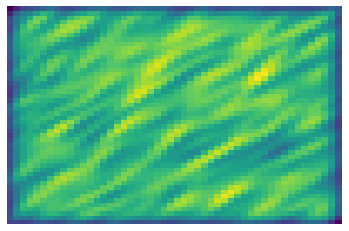

In [20]:
plt.pcolormesh(x.reshape(50,50))
#plt.colorbar()
plt.axis('off')
plt.savefig('output.pdf')

Can we augment the candidate vector?  Take a vector of ones and the old solution (error) vector.

In [8]:
B = np.vstack((np.ones(A.shape[0],), x)).T

In [9]:
B.shape

(2500, 2)

In [10]:
ml = pyamg.smoothed_aggregation_solver(A, B, max_coarse=1, keep=True)

In [11]:
print(ml)

multilevel_solver
Number of Levels:     5
Operator Complexity:  1.488
Grid Complexity:      1.264
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         2500        21904 [67.19%]
    1          578         9604 [29.46%]
    2           72         1024 [ 3.14%]
    3            8           64 [ 0.20%]
    4            2            4 [ 0.01%]



In [12]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res[1:] / res[:-1]

array([0.0971536 , 0.61698692, 0.70360744, 0.74709174, 0.77597098,
       0.79747127, 0.81434001, 0.82777481, 0.83849447, 0.84706257,
       0.85395585, 0.8595691 , 0.86421596, 0.86813649, 0.87150938,
       0.87446501, 0.87709719, 0.87947281, 0.88163935, 0.88363047,
       0.88547016, 0.88717574, 0.88875994, 0.89023246, 0.89160102,
       0.89287204, 0.89405115, 0.89514348, 0.8961539 , 0.89708706,
       0.89794752, 0.89873972, 0.899468  , 0.90013658, 0.90074957,
       0.90131091, 0.90182439, 0.90229362, 0.90272201, 0.90311279,
       0.90346899, 0.90379345, 0.9040888 , 0.90435749, 0.9046018 ,
       0.90482383, 0.9050255 , 0.9052086 , 0.90537477, 0.90552549,
       0.90566215, 0.90578601, 0.9058982 , 0.90599977, 0.9060917 ,
       0.90617484, 0.90625   , 0.9063179 , 0.9063792 , 0.90643451,
       0.90648437, 0.90652929, 0.90656972, 0.90660608, 0.90663874,
       0.90666805, 0.90669432, 0.90671783, 0.90673885, 0.90675761,
       0.90677432, 0.90678919, 0.90680238, 0.90681406])

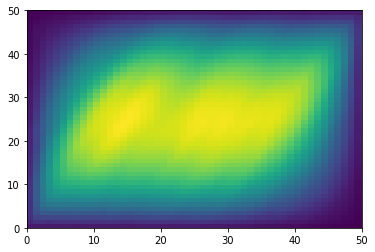

In [13]:
plt.pcolormesh(x.reshape(50,50))

In [14]:
ml

multilevel_solver
Number of Levels:     5
Operator Complexity:  1.488
Grid Complexity:      1.264
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         2500        21904 [67.19%]
    1          578         9604 [29.46%]
    2           72         1024 [ 3.14%]
    3            8           64 [ 0.20%]
    4            2            4 [ 0.01%]

In [15]:
ml.levels[0].P.shape

(2500, 578)

In [16]:
ml.levels[0].AggOp.shape

(2500, 289)

# Try Adaptive AMG

In short, adaptive AMG will run a cycle on $Ax=0$ to determine improved $B$ vectors

In [17]:
mladapt, work = pyamg.aggregation.adaptive_sa_solver(A, num_candidates=3)
print(mladapt)

multilevel_solver
Number of Levels:     4
Operator Complexity:  2.098
Grid Complexity:      1.395
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         2500        21904 [47.66%]
    1          867        21609 [47.02%]
    2          108         2304 [ 5.01%]
    3           12          144 [ 0.31%]



Let's look at the candidate vectors

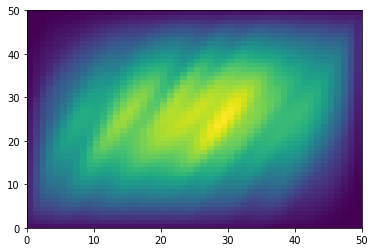

In [18]:
plt.pcolormesh(mladapt.levels[0].B[:,0].reshape(50,50))

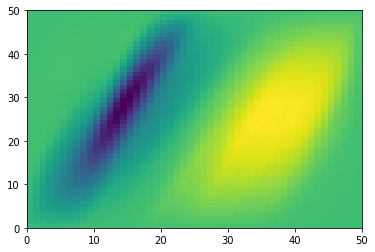

In [19]:
plt.pcolormesh(mladapt.levels[0].B[:,1].reshape(50,50))

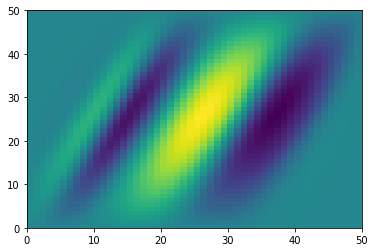

In [20]:
plt.pcolormesh(mladapt.levels[0].B[:,2].reshape(50,50))

In [21]:
ml = pyamg.smoothed_aggregation_solver(A, mladapt.levels[0].B, max_coarse=1)
print(ml)

multilevel_solver
Number of Levels:     5
Operator Complexity:  2.099
Grid Complexity:      1.396
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         2500        21904 [47.65%]
    1          867        21609 [47.01%]
    2          108         2304 [ 5.01%]
    3           12          144 [ 0.31%]
    4            3            9 [ 0.02%]



# Check the convergence

Let's see how well improved candidate vectors work for both a SA and adaptive SA method.

In [22]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res[1:] / res[:-1]

array([0.10938388, 0.35417254, 0.45706923, 0.50313011, 0.53135075,
       0.54894956, 0.56013317, 0.56760379, 0.57296644, 0.57716588,
       0.58078788, 0.58423062, 0.58779394, 0.59172075, 0.5962092 ,
       0.60140445, 0.60737698])

In [23]:
res = []
x = mladapt.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res[1:] / res[:-1]

array([0.13851597, 0.39670044, 0.47979561, 0.53539309, 0.57823153,
       0.61279865, 0.64059862, 0.66200395, 0.67761586, 0.68847846,
       0.69578221, 0.70058655, 0.70370811, 0.70572534, 0.70702831,
       0.70787282, 0.70842408, 0.70878799, 0.70903219, 0.70919983,
       0.70931843, 0.70940552, 0.70947227, 0.70952576])

# Improving SOC

In [24]:
B = np.ones((A.shape[0],1))
ml = pyamg.smoothed_aggregation_solver(A, B, strength='evolution', max_coarse=5)
print(ml)

multilevel_solver
Number of Levels:     5
Operator Complexity:  1.342
Grid Complexity:      1.206
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         2500        21904 [74.53%]
    1          425         5891 [20.04%]
    2           78         1492 [ 5.08%]
    3           10          100 [ 0.34%]
    4            2            4 [ 0.01%]



In [25]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res[1:] / res[:-1]

array([0.33685198, 0.30025907, 0.47242675, 0.62722361, 0.6958938 ,
       0.73107573, 0.75345159, 0.7691182 , 0.78057313, 0.7891501 ,
       0.79568061, 0.80072854, 0.80469238, 0.80785885, 0.81043561,
       0.8125732 , 0.81438068, 0.81593692, 0.81729895, 0.818508  ,
       0.81959392, 0.82057847, 0.82147759, 0.8223031 , 0.82306395,
       0.82376703, 0.8244178 , 0.82502074, 0.82557962, 0.82609773,
       0.826578  , 0.82702311, 0.82743555, 0.82781764, 0.82817158,
       0.82849945, 0.82880321, 0.82908472, 0.82934574, 0.82958794,
       0.82981285, 0.83002194])

# Improving Interpolation

In [26]:
B = np.ones((A.shape[0],1))
smooth=('energy', {'krylov': 'cg', 'maxiter': 4, 'degree': 3, 'weighting': 'local'})
ml = pyamg.smoothed_aggregation_solver(A, B, strength='evolution', max_coarse=5,
                                       smooth=smooth)
print(ml)

multilevel_solver
Number of Levels:     4
Operator Complexity:  1.711
Grid Complexity:      1.185
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         2500        21904 [58.45%]
    1          425        14673 [39.15%]
    2           36          898 [ 2.40%]
    3            1            1 [ 0.00%]



In [27]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res[1:] / res[:-1]

array([0.75319336, 0.49989532, 0.3969652 , 0.38234169, 0.38012928,
       0.38010047, 0.38041582, 0.38073187, 0.38099346, 0.38120087,
       0.38136364, 0.3814915 , 0.38159275])

In [28]:
res

array([2.86414001e+01, 2.15725124e+01, 1.07839979e+01, 4.28087192e+00,
       1.63675580e+00, 6.22178798e-01, 2.36490451e-01, 8.99647099e-02,
       3.42524321e-02, 1.30499526e-02, 4.97465331e-03, 1.89715189e-03,
       7.23747317e-04, 2.76176727e-04])